In [1]:
#Code Written by Diana Lewis
## Code edited and debugged by Matthew Miller
## Additional help from ChatGPT and Label Studio documentation
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, ZeroPadding2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from torchvision import transforms as T
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras import backend as K  
import random 

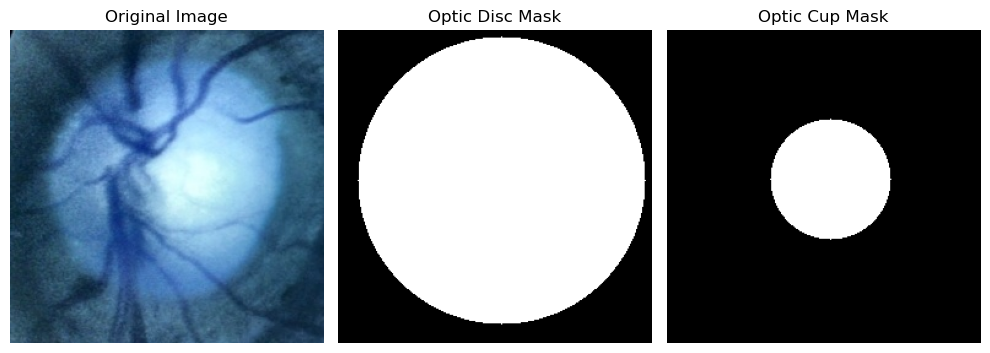

In [3]:
def read_images_and_masks(folder_path):
    images = []
    disc_masks = []
    cup_masks = []

    # Get list of files in the folder
    files = os.listdir(folder_path)

    # Sort files to ensure they are read in the correct order
    files.sort()

    for file in files:
        if file.startswith('image_'):
            # Read and append image
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path)
            images.append(image)
        elif file.startswith('optic_disc_mask_'):
            # Read and append optic disc mask
            mask_path = os.path.join(folder_path, file)
            disc_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            disc_masks.append(disc_mask)
        elif file.startswith('optic_cup_mask_'):
            # Read and append optic cup mask
            mask_path = os.path.join(folder_path, file)
            cup_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            cup_masks.append(cup_mask)

    return images, disc_masks, cup_masks

# Define the path to the folder containing the images and masks
folder_path = 'Glaucoma_Balanced_Dataset/Diana_Output/'

# Read images and masks
resized_images, disc_masks, cup_masks = read_images_and_masks(folder_path)

# Display the first image and its corresponding masks
if resized_images:
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(resized_images[0], cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display optic disc mask
    plt.subplot(1, 3, 2)
    plt.imshow(disc_masks[0], cmap='gray')
    plt.title('Optic Disc Mask')
    plt.axis('off')

    # Display optic cup mask
    plt.subplot(1, 3, 3)
    plt.imshow(cup_masks[0], cmap='gray')
    plt.title('Optic Cup Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the specified folder.")

In [4]:
disc_masks_binary_adjusted = disc_masks
cup_masks_binary_adjusted = cup_masks

type(disc_masks_binary_adjusted)

list

In [5]:
#Segmentation of Optic Disc 
# Define U-Net model
def gnet_disc(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    up6 = UpSampling2D(size=(2, 2))(conv5)
    
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = UpSampling2D(size=(2, 2))(conv7)
   
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

# Example usage
input_shape = (256, 256, 3)
num_classes = 1
disc_model = gnet_disc(input_shape, num_classes)
#model.summary()

# Split the data into training and validation sets
# Convert the lists to numpy arrays
X = np.array(resized_images)
y = np.array(disc_masks_binary_adjusted)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert y_train and y_val to float and expand the dimensions
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

#y_train = np.squeeze(y_train, axis= 5)
#y_val = np.squeeze(y_val, axis= 5)

# Compile the model with Adam optimizer and reduced learning rate
opt = optimizers.Adam(clipvalue=0.5)
disc_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


# Add a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Train generator
image_generator = image_datagen.flow(X_train, batch_size=2, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=2, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)




In [6]:
# Define a function to calculate sensitivity and specificity
#def calculate_metrics(y_true, y_pred):
    #accuracy = accuracy_score(y_true, y_pred)
    #precision = precision_score(y_true, y_pred)
    #recall = recall_score(y_true, y_pred)
    
    #sensitivity = recall  # Sensitivity is the same as recall
    #specificity = accuracy - (1 - precision)
    
    #return sensitivity, specificity
    


# Compute the total number of augmented images per epoch
total_samples = len(X_train)  # Number of original images
augmentation_factor = 15  # Number of augmented images generated per original image
images_per_epoch = total_samples * augmentation_factor

# Compute steps_per_epoch based on batch_size
batch_size = 5 #CHANGE THIS 
steps_per_epoch = images_per_epoch // batch_size

# Train the model
history = disc_model.fit(train_generator, validation_data=(X_val, y_val), 
                    steps_per_epoch=steps_per_epoch, epochs=5, verbose=1)

disc_model.save_weights("disc_segmentation_weights.h5")
disc_model.load_weights("disc_segmentation_weights.h5")

# Calculate sensitivity and specificity for each epoch
def calculate_metrics_disc(y_true, y_pred):
    #Assuming y_true and y_pred are numpy arrays
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    sensitivity  = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())
    
    return sensitivity, specificity

for i in range(len(history.history['val_loss'])):
    y_pred = disc_model.predict(X_val)
    sens, spec = calculate_metrics_cup(y_val, np.round(y_pred))  # Assuming y_pred needs to be rounded to 0 or 1
    sensitivity.append(sens)
    specificity.append(spec)
    print(f"Epoch {i+1}: Sensitivity = {sens}, Specificity = {spec}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


ValueError: Unrecognized data type: x=<zip object at 0x000001F6CB555E00> (of type <class 'zip'>)

In [ ]:
#Segmentation of Optic Cup 

def gnet_cup(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(34,(4,2), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(34,(4,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)
    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)
    conv3 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)
    conv4 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(4, 4))(conv4)
    conv5 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    up6 = UpSampling2D(size=(4, 4))(conv5)
    
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = UpSampling2D(size=(4, 4))(conv6)
    
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = UpSampling2D(size=(4, 4))(conv7)
   
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = UpSampling2D(size=(4, 4))(conv8)
    
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(34, (4,2), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(34, (4,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

# Example usage
input_shape = (256, 256, 3)
num_classes = 1
cup_model = gnet_cup(input_shape, num_classes)
#model.summary()

# Split the data into training and validation sets
# Convert the lists to numpy arrays
X = np.array(resized_images)
y = np.array(cup_masks_binary_adjusted)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_val = X_val / 255.0

# Reshape X_train and X_val to include channel dimension
#X_train = np.expand_dims(X_train, axis=-1)
#X_val = np.expand_dims(X_val, axis=-1)

# Reshape y_train and y_val to include channel dimension
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Compile the model with Adam optimizer and reduced learning rate
opt = optimizers.Adam(clipvalue=0.5)
cup_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


# Add a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Train generator
image_generator = image_datagen.flow(X_train, batch_size=2, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=2, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# Compute the total number of augmented images per epoch
total_samples = len(X_train)  # Number of original images
augmentation_factor = 15  # Number of augmented images generated per original image CHANGE THIS 
images_per_epoch = total_samples * augmentation_factor

# Compute steps_per_epoch
batch_size = 5 #CHANGE THIS 
steps_per_epoch = len(X_train) // batch_size


# Train the model
#history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=10, verbose=1)
# Train the model
history = cup_model.fit(train_generator, validation_data=(X_val, y_val), 
                    steps_per_epoch=images_per_epoch // batch_size, epochs=5, verbose=1)

# Save cup segmentation model weights
cup_model.save_weights("cup_segmentation_weights.h5")
cup_model.load_weights("cup_segmentation_weights.h5")

# Calculate sensitivity and specificity for each epoch
def calculate_metrics_cup(y_true, y_pred):
    #Assuming y_true and y_pred are numpy arrays
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    sensitivity  = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())
    
    return sensitivity, specificity

for i in range(len(history.history['val_loss'])):
    y_pred = cup_model.predict(X_val)
    sens, spec = calculate_metrics_cup(y_val, np.round(y_pred))  # Assuming y_pred needs to be rounded to 0 or 1
    sensitivity.append(sens)
    specificity.append(spec)
    print(f"Epoch {i+1}: Sensitivity = {sens}, Specificity = {spec}")


#print("Last batch prediction shape:", y_pred.shape)
#print("Last batch prediction values:", y_pred)
#print("Last batch true labels shape:", y_batch.shape)
#print("Last batch true labels values:", y_batch)


# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Output of segmentation masks to be used for classification
# Predict cup masks for test images using cup segmentation model (cup_model)
predicted_cup_masks = [cup_model.predict(np.expand_dims(image, axis=0)) for image in resized_images]

# Predict disc masks for test images using disc segmentation model (disc_model)
predicted_disc_masks = [disc_model.predict(np.expand_dims(image, axis=0)) for image in resized_images]

def overlay_cup_mask(image, cup_mask, alpha=0.3):
    # Resize mask to match image size
    cup_mask = cv2.resize(cup_mask, (image.shape[1], image.shape[0]))
    cup_mask = (cup_mask > 0.9).astype(np.uint8)  # Binarize mask
    kernel = np.ones((3, 3), np.uint8)
    cup_mask = cv2.morphologyEx(cup_mask, cv2.MORPH_OPEN, kernel)  # Apply morphological opening
    overlay = image.copy()
    overlay[cup_mask == 1] = (0, 255, 0)  # Green color for the cup mask
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image

def overlay_disc_mask(image, disc_mask, alpha=0.3):
    # Resize mask to match image size
    disc_mask = cv2.resize(disc_mask, (image.shape[1], image.shape[0]))
    disc_mask = (disc_mask > 0.1).astype(np.uint8)  # Binarize mask
    
    # Apply morphological closing to make the disc mask circular
    disc_mask = cv2.morphologyEx(disc_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))
    
    overlay = image.copy()
    overlay[disc_mask == 1] = (255, 0, 0)  # Red color for the disc mask
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image

def display_overlay(original_image, image_with_masks, cup_mask, disc_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.subplot(1, 4, 2)
    plt.imshow(image_with_masks)
    plt.title('Image with Overlayed Masks')
    plt.subplot(1, 4, 3)
    plt.imshow(cup_mask, cmap='gray')
    plt.title('Cup Mask')
    plt.subplot(1, 4, 4)
    plt.imshow(disc_mask, cmap='gray')
    plt.title('Disc Mask')
    plt.show()

# Display images with overlayed masks
for i in range(len(resized_images)):
    original_image = (resized_images[i] * 255).astype(np.uint8)
    cup_mask = (predicted_cup_masks[i][0, :, :, 0] * 255).astype(np.uint8)
    disc_mask = (predicted_disc_masks[i][0, :, :, 0] * 255).astype(np.uint8)
    image_with_masks = overlay_cup_mask(original_image, cup_mask)
    image_with_masks = overlay_disc_mask(image_with_masks, disc_mask)
    display_overlay(original_image, image_with_masks, cup_mask, disc_mask)

In [ ]:
# Load ground truth classifications from CSV file
ground_truth_dict = {}
csv_file = "Glaucoma_Balanced_Dataset/Preprocessed_images_input_to_bound/bounding_box_labels_adjusted_CDR_CSV.csv"
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        if row[5] == 'NRG':
            ground_truth_dict[row[0]] = 0  # Not Glaucoma
        elif row[5] == 'RG':
            ground_truth_dict[row[0]] = 1  # Glaucoma

In [ ]:
def calculate_diameters(cup_mask, disc_mask):
   # Calculate the contour of the segmented cup mask
    cup_contours, _ = cv2.findContours(cup_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate the contour of the segmented disc mask
    disc_contours, _ = cv2.findContours(disc_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour for optic cup
    cup_contour = max(cup_contours, key=cv2.contourArea)
    # Find the largest contour for optic disk
    disc_contour = max(disc_contours, key=cv2.contourArea)
    
    # Calculate the diameter of optic cup
    _, _, cup_width, cup_height = cv2.boundingRect(cup_contour)
    cup_diameter = max(cup_width, cup_height)
    
    # Calculate the diameter of optic disk
    _, _, disc_width, disc_height = cv2.boundingRect(disc_contour)
    disc_diameter = max(disc_width, disc_height)
    
    return cup_diameter, disc_diameter

# Calculate cup and disk diameters and CDR values
optic_cup_diameters = []
optic_disc_diameters = []
for cup_mask, disc_mask in zip(cup_masks, disc_masks):
    cup_diameter, disc_diameter = calculate_diameters(cup_mask, disc_mask)
    optic_cup_diameters.append(cup_diameter)
    optic_disc_diameters.append(disc_diameter)

# Convert lists to numpy arrays
X = np.array(X)  # Assuming X is a list of images
optic_cup_diameters = np.array(optic_cup_diameters)
optic_disc_diameters = np.array(optic_disc_diameters)

# Calculate CDR
#cdr_values = [cup_diameter / disk_diameter for cup_diameter, disk_diameter in zip(optic_cup_diameters, optic_disk_diameters)]

# Calculate CDR
cdr_values = optic_cup_diameters / optic_disc_diameters

# Convert CDR values to binary labels
y = np.where(cdr_values > 0.65, 1, 0)

# Convert CDR values to binary labels
# y = [1 if cdr > 0.65 else 0 for cdr in cdr_values]
